In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from RNN import RNN

import sys
import time
import random
import numpy as np
import cv2  # conda install opencv
import pickle


import matplotlib.pyplot as plt
from tabulate import tabulate
from utils import printProgressBar

def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()

%matplotlib notebook

In [2]:
# # READ IN THE TRAINING DATA:

# fname = 'DS1.dat'

# with open(fname, 'rb') as f:
#     dat = pickle.load(f)
    
# IMG = dat['img']
# joints = dat['joints']
# times = dat['t']

# print(tabulate([['Samples in vis. input', IMG.__len__()],
#                 ['Shape of joint angles', joints.__len__()],
#                 ['Rec time, sec', times.max()-times.min()]],
#                headers=['Dataset stats', '']))

In [3]:
# %matplotlib inline
# plt.figure(figsize=(20,5))
# # plt.tight_layout()
# for i in range(6):
#     plt.plot(dat['joints'][:, i], label='joint {}'.format(i+1))
# plt.legend()
# # plt.axvline(25.1, c='grey', linestyle='-.', linewidth=0.4)
# # plt.axvline(121.8, c='grey', linestyle='-.', linewidth=0.4)

In [4]:
# %matplotlib inline

# # start_idx = np.argmin(np.abs(dat['t']-0.0))
# # stop_idx = np.argmin(np.abs(dat['t']-194.12))

# start_idx = 0
# stop_idx = dat['joints'].shape[0]


# plt.figure(figsize=(20,5))
# plt.tight_layout()
# for i in range(6):
# #     plt.plot(dat['t'][start_idx:stop_idx], dat['joints'][start_idx:stop_idx, i], label='joint {}'.format(i+1))
#     plt.plot(dat['joints'][start_idx:stop_idx, i], label='joint {}'.format(i+1))
# plt.legend()
# plt.axvline(25.1, c='grey', linestyle='-.', linewidth=0.4)
# plt.axvline(121.8, c='grey', linestyle='-.', linewidth=0.4)
# plt.title('Trimmed data')

# IMG = dat['img'][start_idx:stop_idx, :,:,:]
# joints = dat['joints'][start_idx:stop_idx, :]
# times = dat['t'][start_idx:stop_idx]

# print(tabulate([['Samples in vis. input', IMG.__len__()],
#                 ['Shape of joint angles', joints.__len__()],
#                 ['Rec time, sec', times.max()-times.min()]],
#                headers=['Dataset stats', '']))

In [5]:
# # prep the data:

# joints /= 4.0

# img = np.stack(IMG)
# img = img.transpose(0,3,1,2) #B x C x H x W
# img = img[:,0,:,:]           # select only the red channel
# img = img[:,None, :,:]       # squeeze the tensor
# visual_input = torch.tensor(img, dtype=torch.float).cuda()

# # prepare visual targets (they should be the same as the inputs only one step ahead)
# visual_target = np.roll(img, -1, axis=0)
# visual_target = torch.tensor(visual_target, dtype=torch.float).cuda()

# motor_input = torch.tensor(joints, dtype=torch.float).cuda()

# target_joints = np.roll(joints, -1, axis=0)
# motor_target = torch.tensor(target_joints, dtype=torch.float).cuda()

# print(tabulate([['Visual input shape', img.shape],
#                 ['Visual target shape', visual_target.shape],
#                 ['Motor target shape', motor_target.shape]],
#                headers=['Preprocessed dataset stats', '']))

# # check if the inputs have really been rolled as needed:
# print([torch.sum(visual_input[i+1] - visual_target[i]).item() for i in range(10)])
# print([torch.sum(motor_input[i+1] - motor_target[i]).item() for i in range(10)])

In [2]:
%time

def loadset(device):
    fname = np.random.choice(['DS0.dat', 'DS1.dat','DS2.dat','DS3.dat'])

    with open(fname, 'rb') as f:
        dat = pickle.load(f)

    IMG = dat['img']
    joints = dat['joints']
    times = dat['t']

    joints /= 4.0

    img = np.stack(IMG)
    img = img.transpose(0,3,1,2) #B x C x H x W
    img = img[:,0,:,:]           # select only the red channel
    img = img[:,None, :,:]       # squeeze the tensor
    visual_input = torch.tensor(img, dtype=torch.float).to(device)

    # prepare visual targets (they should be the same as the inputs only one step ahead)
    visual_target = np.roll(img, -1, axis=0)
    visual_target = torch.tensor(visual_target, dtype=torch.float).to(device)

    motor_input = torch.tensor(joints, dtype=torch.float).to(device)

    target_joints = np.roll(joints, -1, axis=0)
    motor_target = torch.tensor(target_joints, dtype=torch.float).to(device)
    return IMG, joints, visual_input, motor_input, visual_target, motor_target

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [3]:
input_size  = 46
hidden_size = 46
output_size = 46
cell_type = 'GRU'

EPOCHS = 50000
device = 'cuda'

criterion = nn.MSELoss()

rnn = RNN(cell_type, input_size, hidden_size, output_size).to(device)

# rnn.load_state_dict(torch.load('checkpoint'))

hidden = rnn.initHidden(device=device)
IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device)
visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)

In [5]:
# rnn.load_state_dict(torch.load('checkpoint'))

<All keys matched successfully>

In [13]:
# torch.save(rnn.state_dict(), 'checkpoint')

In [4]:
VLOSS, MLOSS = [], []
# name = ''.join(random.sample('abcdefgh1234567890', 10))
name = '218g7bh063'
writer = SummaryWriter('runs/' + name)

In [6]:
rnn.optimizer = optim.Adam(rnn.parameters(), lr=0.0005)
# rnn.optimizer = optim.Adam(rnn.parameters())

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
for epoch in range(EPOCHS):
    try:
        f = open('log.txt', 'a')
        rnn.optimizer.zero_grad()
        hidden = rnn.initHidden(device) # re-init hidden state to zero
#         if epoch%5 == 0:
#             IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device)
        visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)
        motor_loss = criterion(motor_output, motor_target)
        visual_loss = criterion(visual_output, visual_target)

        if visual_loss > motor_loss:
            motor_loss_mult = visual_loss.item() / motor_loss.item()
        else:
            motor_loss_mult = 1.0
        
        l2_reg = torch.zeros(1,)
#         for param in rnn.parameters():
#             l2_reg += torch.norm(param)
            
#         loss = motor_loss_mult*motor_loss + visual_loss# + 0.001*l2_reg
        loss = motor_loss_mult*motor_loss + visual_loss 
        
        loss.backward()
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        rnn.optimizer.step()
        printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.2f} mloss: {:.6f} l2: {:.3f}'.format(epoch, visual_loss.item(), motor_loss.item(), l2_reg.item()), suffix='Complete', length=25)
        f.write('Motor loss: {:.2f} Visual loss: {:.2f} \n'.format(motor_loss.item(), visual_loss.item()))
        f.close()
        if epoch % 1000 == 0:
            # save model parameters:
            torch.save(rnn.state_dict(), 'checkpoint')
            # save model performance:
            f = open('dump1.pickle', 'wb')
            dat = {'vinp': visual_input.cpu().detach().numpy(),
                   'vout': visual_output.cpu().detach().numpy(),
                   'mi': motor_input.cpu().detach().numpy(),
                   'mo': motor_output.cpu().detach().numpy()}
            pickle.dump(dat, f)
            f.close()
    except KeyboardInterrupt:
        print('\nStopped')
        break
        

Epoch: 316 vloss: 1518.99 mloss: 0.004034 l2: 0.000 |-------------------------| 0.6% Complete
Stopped


In [9]:
""" with prediction feedback """


rnn.optimizer = optim.Adam(rnn.parameters(), lr=0.0005)
# rnn.optimizer = optim.Adam(rnn.parameters())
pred_fb = 0.1                                 # fraction of feedback at each step (ground truth = 1 - pred_fb)

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
for epoch in range(EPOCHS):
    try:
        if epoch%5 == 0:
            IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device)
        
        # forward the first step in the sequence:
        hidden = rnn.initHidden(device=device)
        visual_output, motor_output, hidden = rnn(visual_input[0].unsqueeze(0),
                                                  motor_input[0].unsqueeze(0),
                                                  hidden)  
        rnn.optimizer.zero_grad()
        loss = torch.zeros(1,).to(device)
        
        for i in range(1, motor_input.shape[0]):
            visual_output, motor_output, hidden = rnn(visual_input[i].unsqueeze(0)*(1-pred_fb) + visual_output*pred_fb,
                                                      motor_input[i].unsqueeze(0)*(1-pred_fb) + motor_output.unsqueeze(0)*pred_fb,
                                                      hidden)

            motor_loss = criterion(motor_output.unsqueeze(0), motor_target[i].unsqueeze(0))
            visual_loss = criterion(visual_output, visual_target[i].unsqueeze(0))

            if visual_loss > motor_loss:
                motor_loss_mult = visual_loss.item() / motor_loss.item()
            else:
                motor_loss_mult = 1.0

            l2_reg = torch.zeros(1,).to(device)
    #         for param in rnn.parameters():
    #             l2_reg += torch.norm(param)

    #         loss = motor_loss_mult*motor_loss + visual_loss# + 0.001*l2_reg
            loss += motor_loss_mult*motor_loss + visual_loss + l2_reg

        loss.backward()
        writer.add_scalar('motor loss', motor_loss, epoch)
        writer.add_scalar('visual loss', visual_loss, epoch)
            
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        rnn.optimizer.step()
        printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.2f} mloss: {:.6f} l2: {:.3f}'.format(epoch, visual_loss.item(), motor_loss.item(), l2_reg.item()), suffix='Complete', length=25)
        if epoch % 1000 == 0:
            torch.save(rnn.state_dict(), 'checkpoint')

    except KeyboardInterrupt:
        print('\nKeyboard Interrupt')
        break
        

Epoch: 0 vloss: 17198.98 mloss: 0.284184 l2: 0.000 |-------------------------| 0.0% Complete
Keyboard Interrupt


In [33]:
with open('optimizer.state', 'wb') as f:
    pickle.dump(rnn.optimizer.state_dict(), f)

In [34]:
with open('optimizer.state', 'rb') as f:
    rnn.optimizer.load_state_dict(pickle.load(f))

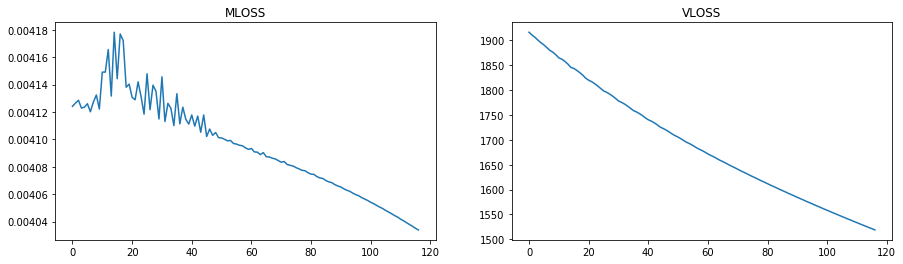

In [7]:
s = 200
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title("MLOSS")
ax1.plot(MLOSS[s:])
ax2.set_title("VLOSS")
ax2.plot(VLOSS[s:])

In [14]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
                                          motor_input[i,:].unsqueeze_(0),
                                          hidden)
        im2 = cv2.resize(visual_output.squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

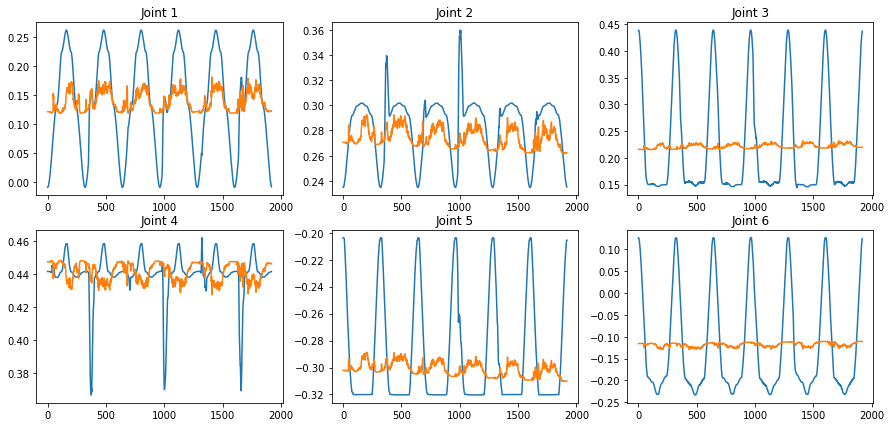

In [8]:
%matplotlib inline
IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device)
OUT = []
for i in range(len(IMG)):
    visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
                                      motor_input[i,:].unsqueeze_(0),
                                      hidden)
    OUT.append(motor_output.cpu().detach().numpy())
OUT = np.stack(OUT)
IN = motor_input.cpu().detach().numpy()

plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(IN[:, i])
    plt.plot(OUT[:, i])
    plt.title('Joint {}'.format(i+1))